In [1]:
# Install additional libraries
!pip install imbalanced-learn

In [7]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

In [23]:
# Import the dataset
dataset = pd.read_csv('/content/drive/MyDrive/Analysis/Credit Risk Analysis/data/[raw]full_loan_data.csv')
dataset = dataset.drop_duplicates() # Remove duplicates in the dataset
dataset.head()

,age,sex,education,income,emp_exp,home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [24]:
# Show the information of each columns
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             45000 non-null  float64
 1   sex                             45000 non-null  object 
 2   education                       45000 non-null  object 
 3   income                          45000 non-null  float64
 4   emp_exp                         45000 non-null  int64  
 5   home_ownership                  45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

The dataset doesn't have any missing values.

In [25]:
# Show the descriptive statistics of the dataset
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,45000.0,27.764178,6.045108,20.00,24.00,26.00,30.00,144.00
income,45000.0,80319.053222,80422.498632,8000.00,47204.00,67048.00,95789.25,7200766.00
emp_exp,45000.0,5.410333,6.063532,0.00,1.00,4.00,8.00,125.00
loan_amnt,45000.0,9583.157556,6314.886691,500.00,5000.00,8000.00,12237.25,35000.00
loan_int_rate,45000.0,11.006606,2.978808,5.42,8.59,11.01,12.99,20.00
loan_percent_income,45000.0,0.139725,0.087212,0.00,0.07,0.12,0.19,0.66
cb_person_cred_hist_length,45000.0,5.867489,3.879702,2.00,3.00,4.00,8.00,30.00
credit_score,45000.0,632.608756,50.435865,390.00,601.00,640.00,670.00,850.00
loan_status,45000.0,0.222222,0.415744,0.00,0.00,0.00,0.00,1.00


## **Feature 1 : `age`**

As we can see in the descriptive statistics of the dataset, there might be some outliers, because the maximum value of this column is 144. This is unusual, as the oldest recorded human age in modern history is 122 years. So, we will detect the anomalies (potential outliers) using the classic—Interquartile Range (IQR) method.

In [26]:
# Detect anomalies using IQR
# Calculate the upper and lower limits
Q1 = dataset['age'].quantile(0.25)
Q3 = dataset['age'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(dataset['age'] >= upper)[0]
lower_array = np.where(dataset['age'] <= lower)[0]

# Show the upper limit and lower limits
print('Upper limit:', upper)
print('Lower limit:', lower)

# Show the amount of data that are higher than the upper point and lower than the lower point
print('Amount of data that are higher than the upper limit:', len(upper_array))
print('Amount of data that are lower than the lower limit:', len(lower_array))

Upper limit: 39.0
Lower limit: 15.0
Amount of data that are higher than the upper limit: 2577
Amount of data that are lower than the lower limit: 0


Although the IQR analysis suggests an upper limit of 39.0 and a lower limit of 15.0, we choose not to remove values above the upper bound, as many individuals are reasonably older than 39.0 years. Instead, to ensure data quality while considering realistic human age ranges, we remove entries where the age value exceeds 100 years, which are likely to be data entry errors or extreme outliers.

In [27]:
# Remove rows with age greater than 100 directly in the dataset
dataset = dataset[dataset['age'] <= 100]

# Print the number of remaining rows
print("Number of rows after removing unrealistic age values:", len(dataset))

Number of rows after removing unrealistic age values: 44993


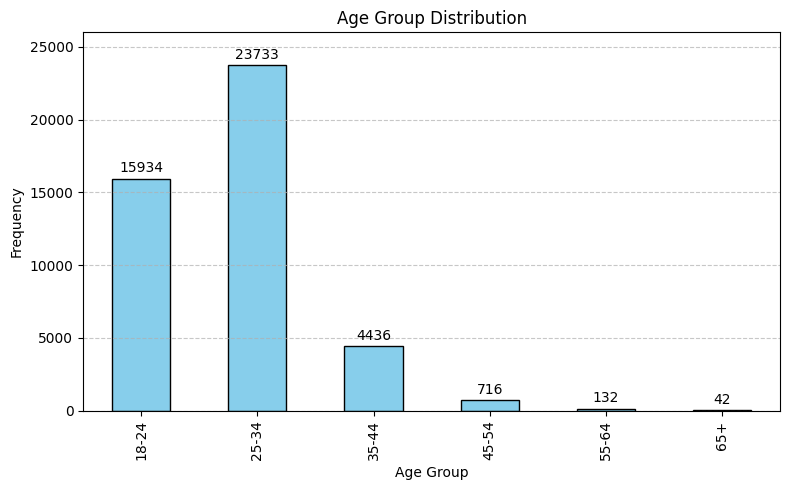

In [30]:
# Define age bins and labels
bins = [18, 24, 34, 44, 54, 64, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Categorize ages without creating a new column in the dataset
age_categories = pd.cut(dataset['age'], bins=bins, labels=labels, right=True)

# Calculate counts per age group
age_group_counts = age_categories.value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(8, 5))
ax = age_group_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add frequency labels on top of bars
for i, count in enumerate(age_group_counts):
    ax.text(i, count + max(age_group_counts) * 0.01, str(count), ha='center', va='bottom')

# Customize plot
ax.set_ylim(0, 26000)
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **Feature 2 : `sex`**

In [31]:
# Display counts of each unique value in 'sex' column
sex_counts = dataset['sex'].value_counts()
print(sex_counts)

sex
male      24836
female    20157
Name: count, dtype: int64


Based on the analysis of the sex column, only two unique categories are present: male and female. This indicates that the gender data is consistent and free from inconsistent or invalid entries, which is important to maintain data quality. The absence of unexpected or misspelled categories simplifies demographic segmentation and supports reliable credit risk analysis.

All categorical columns with object data types will be converted into numerical values to facilitate analysis and modeling. This encoding step transforms text labels into numbers, which are required by most machine learning algorithms.

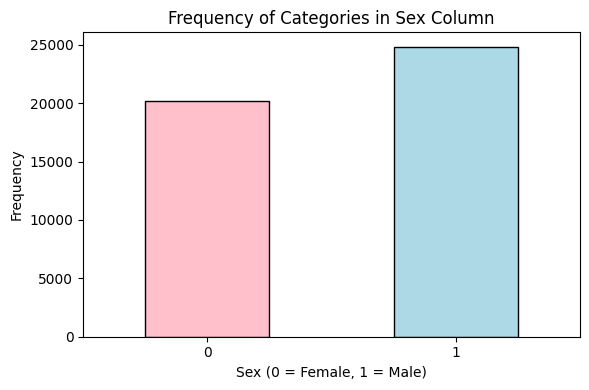

In [32]:
# Map 'female' to 0 and 'male' to 1 in the 'sex' column
dataset['sex'] = dataset['sex'].map({'female': 0, 'male': 1})

# Count the occurrences of each category in 'sex' column
sex_counts = dataset['sex'].value_counts().sort_index()

# Create bar chart
plt.figure(figsize=(6, 4))
sex_counts.plot(kind='bar', color=['pink', 'lightblue'], edgecolor='black')

# Add titles and labels
plt.title('Frequency of Categories in Sex Column')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

## **Feature 3 : `education`**

In [33]:
# Display counts of each unique value in 'education' column
education_counts = dataset['education'].value_counts()
print(education_counts)

education
Bachelor       13396
Associate      12026
High School    11970
Master          6980
Doctorate        621
Name: count, dtype: int64


The education column contains five distinct and valid categories: High School, Associate, Bachelor, Master, and Doctorate. The presence of only these expected values indicates that the data is clean and free from inconsistent or misspelled entries.
To prepare the data for modeling, we will encode these categories into numerical values based on the natural order of educational attainment:
High School (0), Associate (1), Bachelor (2), Master (3), and Doctorate (4).



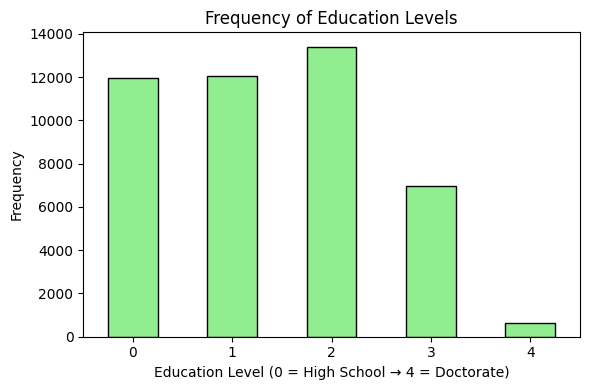

In [34]:
# Encode 'education' column based on level of attainment
education_mapping = {
    'High School': 0,
    'Associate': 1,
    'Bachelor': 2,
    'Master': 3,
    'Doctorate': 4
}
dataset['education'] = dataset['education'].map(education_mapping)

# Count the occurrences of each education level
education_counts = dataset['education'].value_counts().sort_index()

# Create bar chart
plt.figure(figsize=(6, 4))
education_counts.plot(kind='bar', color='lightgreen', edgecolor='black')

# Add titles and labels
plt.title('Frequency of Education Levels')
plt.xlabel('Education Level (0 = High School → 4 = Doctorate)')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

## **Feature 4 : `income`**

The income variable exhibits a wide range of values, with a maximum exceeding USD7,200,766 while the 75th percentile is below  USD100,000. This significant discrepancy suggests the presence of extreme outliers that could distort statistical analysis and model performance. Since income data tends to be positively skewed and not normally distributed, using the Interquartile Range (IQR) method is a more appropriate strategy than z-score for identifying outliers. The IQR method provides a robust, distribution-free approach to detect and filter unrealistic values while preserving the integrity of typical observations.

In [35]:
# Detect anomalies using IQR
# Calculate the upper and lower limits
Q1 = dataset['income'].quantile(0.25)
Q3 = dataset['income'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(dataset['income'] >= upper)[0]
lower_array = np.where(dataset['income'] <= lower)[0]

# Show the upper limit and lower limits
print('Upper limit:', upper)
print('Lower limit:', lower)

# Show the amount of data that are higher than the upper point and lower than the lower point
print('Amount of data that are higher than the upper limit:', len(upper_array))
print('Amount of data that are lower than the lower limit:', len(lower_array))

Upper limit: 168652.5
Lower limit: -25679.5
Amount of data that are higher than the upper limit: 2214
Amount of data that are lower than the lower limit: 0


Based on the IQR analysis, the upper limit for the income variable is approximately USD168,652. While this threshold effectively identifies statistical outliers, it may be too restrictive from a socio-demographic perspective. In reality, there are many individuals who earn above this amount and still rely on credit for various financial purposes such as mortgages, business capital, or lifestyle needs. Therefore, instead of relying solely on the statistical cutoff, we apply a more contextually reasonable upper limit of USD1,000,000 to filter out only the most extreme and unrealistic income values that are unlikely to represent typical credit applicants.

In [36]:
# Remove rows with income greater than USD1,000,000 directly in the dataset
dataset = dataset[dataset['income'] <= 1000000]

# Print the number of remaining rows
print("Number of rows after removing unrealistic age values:", len(dataset))

Number of rows after removing unrealistic age values: 44972


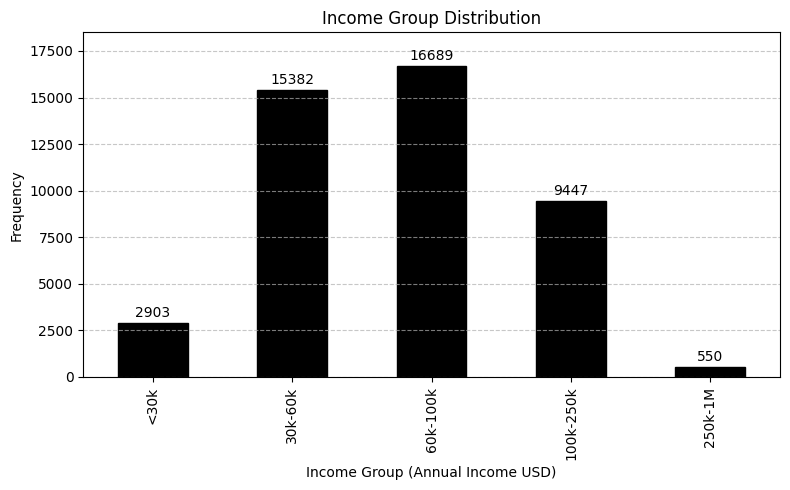

In [39]:
# Define income bins and labels based on socio-demographic brackets (annual income in USD)
max_income = dataset['income'].max()
income_bins = [0, 30000, 60000, 100000, 250000, max_income]
income_labels = ['<30k', '30k-60k', '60k-100k',
                 '100k-250k', '250k-1M']

# Categorize income data without creating new column
income_categories = pd.cut(dataset['income'], bins=income_bins, labels=income_labels, right=False)

# Calculate counts per income category
income_group_counts = income_categories.value_counts().sort_index()

# Plot bar chart
ax = income_group_counts.plot(kind='bar', color='black', edgecolor='black', figsize=(8,5))

# Add frequency labels on top of bars
for i, count in enumerate(income_group_counts):
    ax.text(i, count + max(income_group_counts)*0.01, str(count), ha='center', va='bottom')

# Show the bar chart
ax.set_ylim(0, 18500)
plt.title('Income Group Distribution')
plt.xlabel('Income Group (Annual Income USD)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **Feature 5 : `emp_exp`**

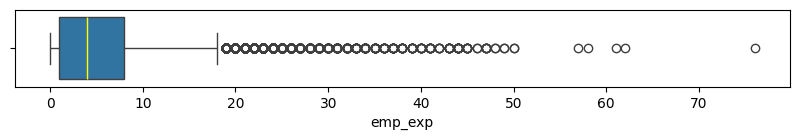

In [40]:
# Show the horizontal boxplot of 'emp_exp'
plt.figure(figsize=(10,1))
ax = sns.boxplot(data=dataset['emp_exp'], orient="h", medianprops=dict(color="yellow", alpha=1))

In [41]:
# Detect anomalies using IQR
# Calculate the upper and lower limits
Q1 = dataset['emp_exp'].quantile(0.25)
Q3 = dataset['emp_exp'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(dataset['emp_exp'] >= upper)[0]
lower_array = np.where(dataset['emp_exp'] <= lower)[0]

# Show the upper limit and lower limits
print('Upper limit:', upper)
print('Lower limit:', lower)

# Show the amount of data that are higher than the upper point and lower than the lower point
print('Amount of data that are higher than the upper limit:', len(upper_array))
print('Amount of data that are lower than the lower limit:', len(lower_array))

Upper limit: 18.5
Lower limit: -9.5
Amount of data that are higher than the upper limit: 1704
Amount of data that are lower than the lower limit: 0


Based on the analysis using the Interquartile Range (IQR) method, the upper limit for the emp_exp (employment experience in years) column was found to be 18.5 years. However, this statistical threshold does not align well with socio-demographic realities. In the real world, it is entirely plausible for individuals to have more than 18.5 years of work experience, especially considering that the analysis tolerates ages up to 100 years. For instance, someone who began working in their early 20s could easily accumulate 30, 40, or even 70+ years of employment experience. Therefore, although these values may appear as anomalies from a statistical standpoint, they are not considered outliers in the context of this analysis. As a result, no records will be removed based on the upper IQR limit for this feature.

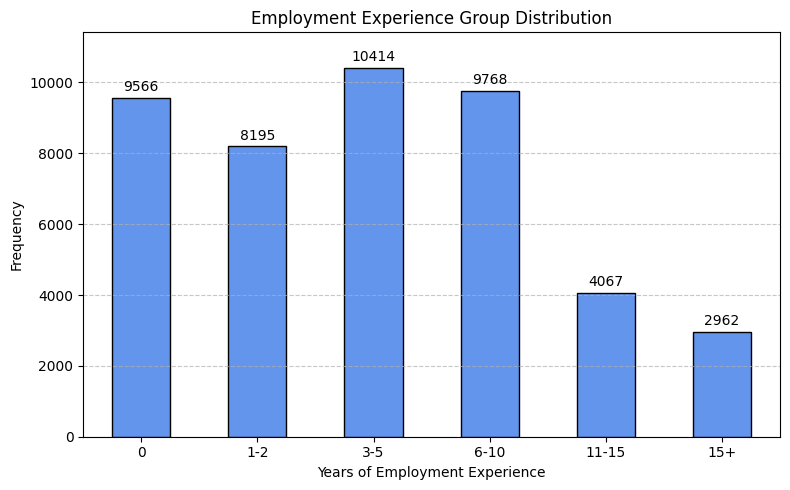

In [45]:
# Define new experience bins and labels
emp_exp_bins = [0, 1, 3, 6, 11, 16, 80]  # upper bound exclusive (right=False)
emp_exp_labels = [
    '0',             # exactly 0 years
    '1-2',           # 1 to <3
    '3-5',           # 3 to <6
    '6-10',          # 6 to <11
    '11-15',         # 11 to <16
    '15+'            # 16 to 100+
]

# Categorize without creating new column
emp_exp_categories = pd.cut(dataset['emp_exp'], bins=emp_exp_bins, labels=emp_exp_labels, right=False)

# Count the frequency for each category
emp_exp_counts = emp_exp_categories.value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(8, 5))
bars = emp_exp_counts.plot(kind='bar', color='cornflowerblue', edgecolor='black')

# Add labels on top of bars
for i, count in enumerate(emp_exp_counts):
    bars.text(i, count + max(emp_exp_counts)*0.01, str(count), ha='center', va='bottom')

# Set chart title and labels
plt.ylim(0, emp_exp_counts.max() + 1000)
plt.title('Employment Experience Group Distribution')
plt.xlabel('Years of Employment Experience')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **Feature 6 : `home_ownership`**

In [46]:
# Display counts of each unique value in 'home_ownership' column
home_ownership_counts = dataset['home_ownership'].value_counts()
print(home_ownership_counts)

home_ownership
RENT        23436
MORTGAGE    18469
OWN          2950
OTHER         117
Name: count, dtype: int64


The home_ownership column contains categorical data representing an individual's housing status. After examining the unique values, we found that all entries fall into four valid and expected categories: RENT, MORTGAGE, OWN, and OTHER. These categories align well with commonly used classifications in financial and socio-demographic datasets. Importantly, no inconsistent or malformed data entries were found in this column, meaning no further cleaning is required before proceeding to the encoding step.

To prepare this column for modeling, we will perform ordinal encoding by converting each category into a numeric value. The encoding will follow a logical order based on the typical stability and creditworthiness associated with each homeownership status in socio-demographic and credit risk contexts. Specifically, individuals who rent generally represent higher credit risk than those with a mortgage, who in turn tend to be less stable than outright homeowners. The OTHER category, being less common and less interpretable, is assigned the highest numerical value. The encoding scheme is as 0 (OTHER), 1(RENT), 2 (MORTGAGE), and 3 (OWN).

This transformation helps the model interpret the progression of financial reliability associated with each homeownership type.

In [47]:
# Perform one-hot encoding on the 'home_ownership' column
home_ownership_dummies = pd.get_dummies(dataset['home_ownership'], prefix='home_ownership')

# Convert boolean dummy columns to integers (0 and 1)
home_ownership_dummies = home_ownership_dummies.astype(int)

# Concatenate the new dummy columns to the original dataset
dataset = pd.concat([dataset, home_ownership_dummies], axis=1)

# Drop the original 'home_ownership' column
dataset.drop('home_ownership', axis=1, inplace=True)

## **Feature 7 : `loan_amnt`**

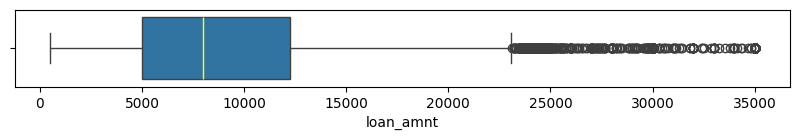

In [48]:
# Show the horizontal boxplot of 'beta'
plt.figure(figsize=(10,1))
ax = sns.boxplot(data=dataset['loan_amnt'], orient="h", medianprops=dict(color="yellow", alpha=1))

In [49]:
# Detect anomalies using IQR
# Calculate the upper and lower limits
Q1 = dataset['loan_amnt'].quantile(0.25)
Q3 = dataset['loan_amnt'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(dataset['loan_amnt'] >= upper)[0]
lower_array = np.where(dataset['loan_amnt'] <= lower)[0]

# Show the upper limit and lower limits
print('Upper limit:', upper)
print('Lower limit:', lower)

# Show the amount of data that are higher than the upper point and lower than the lower point
print('Amount of data that are higher than the upper limit:', len(upper_array))
print('Amount of data that are lower than the lower limit:', len(lower_array))

Upper limit: 23088.75
Lower limit: -5853.25
Amount of data that are higher than the upper limit: 2344
Amount of data that are lower than the lower limit: 0


The loan_amnt column represents the amount of money borrowed by each individual. Based on the IQR analysis, the upper limit for detecting outliers is approximately 23,088.75. However, the actual maximum loan amount in the dataset is 35,000. While this value exceeds the statistical upper threshold, it still falls within a realistic and acceptable range based on socio-demographic and financial norms. In many lending scenarios, especially in personal and consumer loans, amounts up to $35,000 are commonly offered and approved, particularly for individuals with good creditworthiness. Therefore, despite being above the IQR-based upper limit, such values are considered valid, and no data removal is necessary for this column.

## **Feature 8 : `loan_intent`**

In [50]:
# Display counts of each unique value in 'loan_intent' column
loan_intent_counts = dataset['loan_intent'].value_counts()
print(loan_intent_counts)

loan_intent
EDUCATION            9149
MEDICAL              8544
VENTURE              7810
PERSONAL             7544
DEBTCONSOLIDATION    7142
HOMEIMPROVEMENT      4783
Name: count, dtype: int64


The loan_intent column indicates the stated purpose of the loan as provided by the borrowers. Upon inspection, this column consists of six well-defined and distinct categories: EDUCATION, MEDICAL, VENTURE, PERSONAL, DEBTCONSOLIDATION, and HOMEIMPROVEMENT. All categories appear consistent, with no signs of misspellings, duplications, or unexpected values. These purposes are commonly observed in loan datasets and align with real-world borrowing behavior, reflecting socio-demographic needs such as funding education, covering medical expenses, starting a business, consolidating debt, and improving home conditions. Therefore, no cleaning or correction is required for this column.

To prepare the loan_intent categorical variable for modeling, we applied one-hot encoding to convert each unique category into separate binary columns. This approach prevents the model from assuming any ordinal relationship between loan purposes, ensuring better handling of nominal data in the credit risk analysis.

In [51]:
# Perform one-hot encoding on the 'loan_intent' column
loan_intent_dummies = pd.get_dummies(dataset['loan_intent'], prefix='loan_intent')

# Convert boolean dummy columns to integers (0 and 1)
loan_intent_dummies = loan_intent_dummies.astype(int)

# Concatenate the new dummy columns to the original dataset
dataset = pd.concat([dataset, loan_intent_dummies], axis=1)

# Drop the original 'loan_intent' column
dataset.drop('loan_intent', axis=1, inplace=True)

In [52]:
dataset.head()

,age,sex,education,income,emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,...,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,22.0,0,3,71948.0,0,35000.0,16.02,0.49,3.0,561,...,0,0,0,1,0,0,0,0,1,0
1,21.0,0,0,12282.0,0,1000.0,11.14,0.08,2.0,504,...,0,0,1,0,0,1,0,0,0,0
2,25.0,0,0,12438.0,3,5500.0,12.87,0.44,3.0,635,...,1,0,0,0,0,0,0,1,0,0
3,23.0,0,2,79753.0,0,35000.0,15.23,0.44,2.0,675,...,0,0,0,1,0,0,0,1,0,0
4,24.0,1,3,66135.0,1,35000.0,14.27,0.53,4.0,586,...,0,0,0,1,0,0,0,1,0,0


## **Feature 9 : `loan_int_rate`**

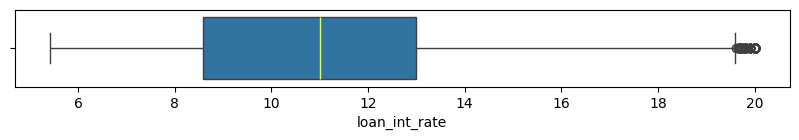

In [53]:
# Show the horizontal boxplot of 'loan_int_rate'
plt.figure(figsize=(10,1))
ax = sns.boxplot(data=dataset['loan_int_rate'], orient="h", medianprops=dict(color="yellow", alpha=1))

In [54]:
# Detect anomalies using IQR
# Calculate the upper and lower limits
Q1 = dataset['loan_int_rate'].quantile(0.25)
Q3 = dataset['loan_int_rate'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(dataset['loan_int_rate'] >= upper)[0]
lower_array = np.where(dataset['loan_int_rate'] <= lower)[0]

# Show the upper limit and lower limits
print('Upper limit:', upper)
print('Lower limit:', lower)

# Show the amount of data that are higher than the upper point and lower than the lower point
print('Amount of data that are higher than the upper limit:', len(upper_array))
print('Amount of data that are lower than the lower limit:', len(lower_array))

Upper limit: 19.615000000000002
Lower limit: 1.9749999999999996
Amount of data that are higher than the upper limit: 124
Amount of data that are lower than the lower limit: 0


The analysis of the loan_int_rate column using the Interquartile Range (IQR) method revealed an upper limit of approximately 19.62%. While 124 records exceed this threshold, the maximum observed interest rate of 20% is still considered reasonable within real-world lending practices. High interest rates are commonly applied to high-risk borrowers or unsecured loans, especially in non-prime lending markets. Therefore, the presence of such values is justifiable from a socio-demographic and credit risk perspective. Consequently, no records were removed based on this threshold, as the data remains realistic and contextually valid.

## **Feature 10 : `loan_percent_income`**

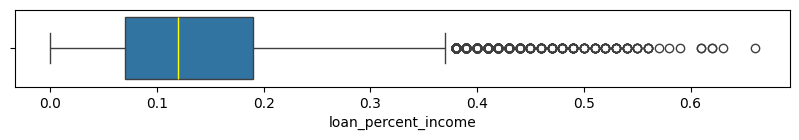

In [55]:
# Show the horizontal boxplot of 'loan_percent_income'
plt.figure(figsize=(10,1))
ax = sns.boxplot(data=dataset['loan_percent_income'], orient="h", medianprops=dict(color="yellow", alpha=1))

In [56]:
# Detect anomalies using IQR
# Calculate the upper and lower limits
Q1 = dataset['loan_percent_income'].quantile(0.25)
Q3 = dataset['loan_percent_income'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(dataset['loan_percent_income'] >= upper)[0]
lower_array = np.where(dataset['loan_percent_income'] <= lower)[0]

# Show the upper limit and lower limits
print('Upper limit:', upper)
print('Lower limit:', lower)

# Show the amount of data that are higher than the upper point and lower than the lower point
print('Amount of data that are higher than the upper limit:', len(upper_array))
print('Amount of data that are lower than the lower limit:', len(lower_array))

Upper limit: 0.37
Lower limit: -0.10999999999999999
Amount of data that are higher than the upper limit: 898
Amount of data that are lower than the lower limit: 0


The loan_percent_income column represents the proportion of a borrower's loan amount relative to their annual income. Based on the IQR analysis, the upper limit is 0.37, while the actual maximum value in the dataset is 0.66. Although 898 records exceed the IQR threshold, these values remain plausible in the context of credit risk analysis. In real-world scenarios, it is not uncommon for individuals to borrow amounts that constitute a high percentage of their income, especially in cases of financial distress or limited access to credit alternatives. Therefore, these records are retained, as they reflect realistic and relevant financial behavior within the socio-demographic landscape.

## **Feature 11 : `cb_person_cred_hist_length`**

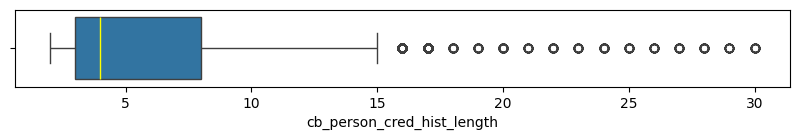

In [57]:
# Show the horizontal boxplot of 'cb_person_cred_hist_length'
plt.figure(figsize=(10,1))
ax = sns.boxplot(data=dataset['cb_person_cred_hist_length'], orient="h", medianprops=dict(color="yellow", alpha=1))

In [58]:
# Detect anomalies using IQR
# Calculate the upper and lower limits
Q1 = dataset['cb_person_cred_hist_length'].quantile(0.25)
Q3 = dataset['cb_person_cred_hist_length'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(dataset['cb_person_cred_hist_length'] >= upper)[0]
lower_array = np.where(dataset['cb_person_cred_hist_length'] <= lower)[0]

# Show the upper limit and lower limits
print('Upper limit:', upper)
print('Lower limit:', lower)

# Show the amount of data that are higher than the upper point and lower than the lower point
print('Amount of data that are higher than the upper limit:', len(upper_array))
print('Amount of data that are lower than the lower limit:', len(lower_array))

Upper limit: 15.5
Lower limit: -4.5
Amount of data that are higher than the upper limit: 1353
Amount of data that are lower than the lower limit: 0


The cb_person_cred_hist_length column indicates the number of years an applicant has maintained a credit history. Based on the IQR analysis, the upper limit is 15.5 years, whereas the actual maximum value in the dataset reaches 30 years. A total of 1,353 records exceed the IQR threshold. However, these values are reasonable and should not be considered outliers, as it is common for individuals—especially older applicants or those with long-term financial engagements—to have extended credit histories. Given the socio-demographic validity of such values, no data removal is performed for this feature.

## **Feature 12 : `credit_score`**

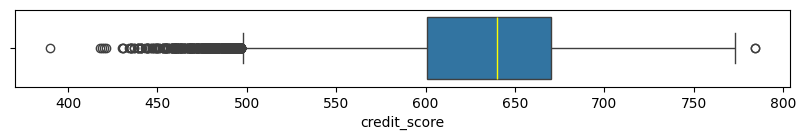

In [59]:
# Show the horizontal boxplot of 'credit_score'
plt.figure(figsize=(10,1))
ax = sns.boxplot(data=dataset['credit_score'], orient="h", medianprops=dict(color="yellow", alpha=1))

In [60]:
# Detect anomalies using IQR
# Calculate the upper and lower limits
Q1 = dataset['credit_score'].quantile(0.25)
Q3 = dataset['credit_score'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(dataset['credit_score'] >= upper)[0]
lower_array = np.where(dataset['credit_score'] <= lower)[0]

# Show the upper limit and lower limits
print('Upper limit:', upper)
print('Lower limit:', lower)

# Show the amount of data that are higher than the upper point and lower than the lower point
print('Amount of data that are higher than the upper limit:', len(upper_array))
print('Amount of data that are lower than the lower limit:', len(lower_array))

Upper limit: 773.5
Lower limit: 497.5
Amount of data that are higher than the upper limit: 2
Amount of data that are lower than the lower limit: 460


The credit_score column represents the applicant’s creditworthiness, typically ranging from 300 to 850. In this dataset, values span from 390 to 850. Based on the IQR analysis, the lower limit is 497.5 and the upper limit is 773.5. There are 460 records below the lower threshold and only 2 above the upper threshold. While the few extremely high scores are valid and should be retained, the large number of credit scores falling below 497.5 deserves attention. However, given that credit scores below 500 still exist in real-world scenarios—often reflecting applicants with poor credit history—it would not be appropriate to treat these as outliers. Therefore, no data removal is performed for this feature, as all values are considered realistic within a socio-demographic context.

## **Feature 13 : `previous_loan_defaults_on_file`**

In [61]:
# Display counts of each unique value in 'previous_loan_defaults_on_file' column
previous_loan_defaults_on_file_counts = dataset['previous_loan_defaults_on_file'].value_counts()
print(previous_loan_defaults_on_file_counts)

previous_loan_defaults_on_file
Yes    22840
No     22132
Name: count, dtype: int64


The previous_loan_defaults_on_file column indicates whether an applicant has previously defaulted on a loan, with two categorical values: "Yes" and "No". Based on the distribution, there are 22,840 applicants with a history of loan default and 22,132 without such history. The categories are clearly defined and consistent, reflecting a typical binary classification relevant to credit risk analysis. No data cleaning is required for this column.

Since this column is categorical and represented as object type, it needs to be converted into numerical values. Therefore, label encoding will be applied, where "No" will be mapped to 0 and "Yes" to 1 to facilitate modeling.

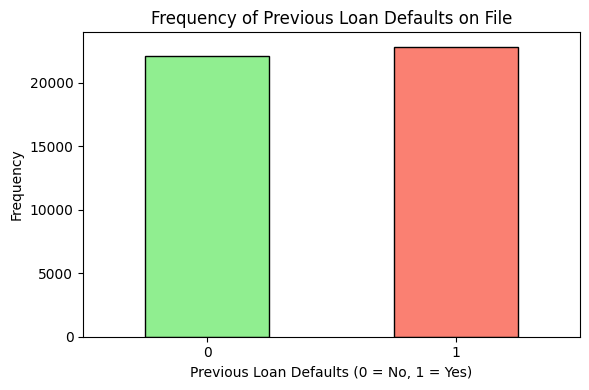

In [62]:
# Perform label encoding: 'No' → 0, 'Yes' → 1
dataset['previous_loan_defaults_on_file'] = dataset['previous_loan_defaults_on_file'].map({'No': 0, 'Yes': 1})

# Count the occurrences of each category in 'previous_loan_defaults_on_file' column
defaults_counts = dataset['previous_loan_defaults_on_file'].value_counts().sort_index()

# Create bar chart
plt.figure(figsize=(6, 4))
defaults_counts.plot(kind='bar', color=['lightgreen', 'salmon'], edgecolor='black')

# Add titles and labels
plt.title('Frequency of Previous Loan Defaults on File')
plt.xlabel('Previous Loan Defaults (0 = No, 1 = Yes)')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

## **Target : `loan_status`**

In [ ]:
# Display counts of each unique value in 'loan_status' column
loan_status_counts = dataset['loan_status'].value_counts()
print(loan_status_counts)

loan_status
0    34972
1    10000
Name: count, dtype: int64


The loan_status column serves as the target variable in this dataset, representing whether a borrower has defaulted (1) or not (0). The values are already encoded in a binary numerical format, with 34,972 records labeled as class 0 and 10,000 as class 1. Each category is clearly defined, and there are no inconsistencies or invalid entries present. This clean and well-structured format makes it ready for use in classification tasks.

In [10]:
# Save dataset into a csv file
dataset.to_csv('/content/drive/MyDrive/Analysis/Credit Risk Analysis/data/[clean]full_loan_data.csv', index=False)

However, it is important to note that the dataset is imbalanced, with a significant disparity between the majority (class 0) and minority (class 1) classes. This imbalance can potentially lead to biased model performance, especially in favor of the majority class.

## **Handling Imbalanced Dataset**

In [12]:
# Load the clean dataset
dataset = pd.read_csv('/content/drive/MyDrive/Analysis/Credit Risk Analysis/data/[clean]full_loan_data.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44972 entries, 0 to 44971
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             44972 non-null  float64
 1   sex                             44972 non-null  int64  
 2   education                       44972 non-null  int64  
 3   income                          44972 non-null  float64
 4   emp_exp                         44972 non-null  int64  
 5   loan_amnt                       44972 non-null  float64
 6   loan_int_rate                   44972 non-null  float64
 7   loan_percent_income             44972 non-null  float64
 8   cb_person_cred_hist_length      44972 non-null  float64
 9   credit_score                    44972 non-null  int64  
 10  previous_loan_defaults_on_file  44972 non-null  int64  
 11  loan_status                     44972 non-null  int64  
 12  home_ownership_MORTGAGE         

To address the imbalanced dataset issue and ensure a fair evaluation, three separate training datasets will be prepared:
(1) an imbalanced dataset without any resampling,
(2) a balanced dataset created using ADASYN for oversampling the minority class, and
(3) a balanced dataset generated using RandomUnderSampler to reduce the majority class.
Each of these training datasets will be paired with the same testing set to allow consistent comparison during model evaluation.

In [13]:
# STEP 1: Separate features and target
X = dataset.drop(columns='loan_status')
y = dataset['loan_status']

# STEP 2: Split into train and test sets (use stratify to preserve class balance in test set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# STEP 3A: Train set (Imbalanced / Original)
train_imbalanced = pd.concat([X_train, y_train], axis=1)

# STEP 3B: Train set with ADASYN (Oversampling)
adasyn = ADASYN(random_state=42, n_neighbors=7)
X_oversampled, y_oversampled = adasyn.fit_resample(X_train, y_train)
train_oversampled = pd.concat([pd.DataFrame(X_oversampled, columns=X.columns),
                               pd.Series(y_oversampled, name='loan_status')], axis=1)

# STEP 3C: Train set with Random Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)
train_undersampled = pd.concat([pd.DataFrame(X_undersampled, columns=X.columns),
                                pd.Series(y_undersampled, name='loan_status')], axis=1)

# STEP 4: Create consistent test set
test_set = pd.concat([X_test, y_test], axis=1)

# OPTIONAL: Display sizes
print("Original Train Set:", train_imbalanced.shape)
print("Oversampled Train Set (ADASYN):", train_oversampled.shape)
print("Undersampled Train Set:", train_undersampled.shape)
print("Test Set:", test_set.shape)


Original Train Set: (35977, 22)
Oversampled Train Set (ADASYN): (55270, 22)
Undersampled Train Set: (16000, 22)
Test Set: (8995, 22)


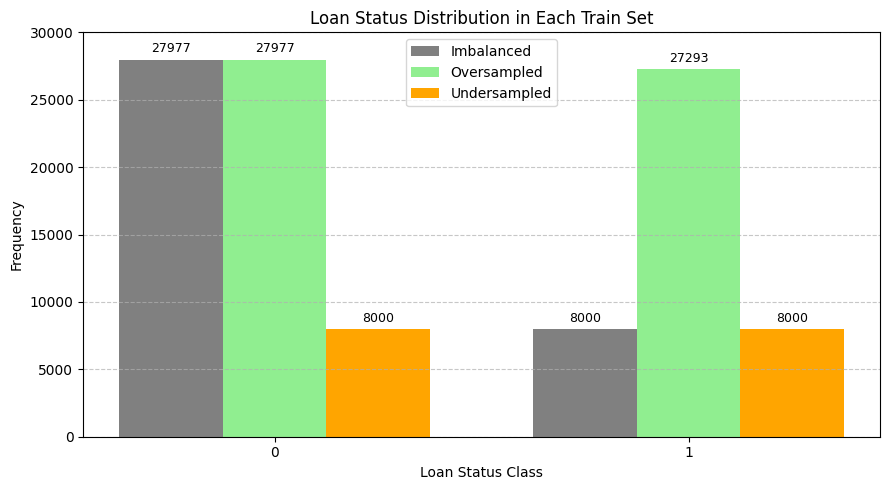

In [22]:
# Get the class distributions
counts_imbalanced = train_imbalanced['loan_status'].value_counts().sort_index()
counts_oversampled = train_oversampled['loan_status'].value_counts().sort_index()
counts_undersampled = train_undersampled['loan_status'].value_counts().sort_index()

# Create a dataframe to align the counts
distribution_df = pd.DataFrame({
    'Imbalanced': counts_imbalanced,
    'Oversampled (ADASYN)': counts_oversampled,
    'Undersampled': counts_undersampled
})

# Bar positions
labels = distribution_df.index.astype(str)
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

# Plot
fig, ax = plt.subplots(figsize=(9, 5))
bar1 = ax.bar(x - width, distribution_df['Imbalanced'], width, label='Imbalanced', color='gray')
bar2 = ax.bar(x, distribution_df['Oversampled (ADASYN)'], width, label='Oversampled', color='lightgreen')
bar3 = ax.bar(x + width, distribution_df['Undersampled'], width, label='Undersampled', color='orange')

# Add frequency labels above each bar
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=9)

# Labeling
ax.set_xlabel('Loan Status Class')
ax.set_ylabel('Frequency')
ax.set_title('Loan Status Distribution in Each Train Set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
ax.set_ylim(0, 30000)
plt.tight_layout()
plt.show()

As a result of the resampling process, three distinct training datasets were successfully prepared to address the class imbalance in the original dataset. The original imbalanced training set consists of 35,977 records, maintaining the natural distribution of the target classes. To mitigate the imbalance, an oversampled training set was generated using the ADASYN algorithm, increasing the number of records to 55,270 by synthetically generating minority class samples. In contrast, an undersampled training set was created using the RandomUnderSampler, reducing the majority class to match the minority class, resulting in a balanced dataset with 16,000 records. All three training sets share a common test set of 8,995 records, which preserves the original distribution and serves as a consistent benchmark for model evaluation. This approach allows for comprehensive comparison of model performance across different strategies for handling class imbalance.

In [14]:
# Save the imbalanced training set
train_imbalanced.to_csv('/content/drive/MyDrive/Analysis/Credit Risk Analysis/data/train_set_imbalanced.csv', index=False)

# Save the oversampled training set
train_oversampled.to_csv('/content/drive/MyDrive/Analysis/Credit Risk Analysis/data/train_set_oversampled.csv', index=False)

# Save the undersampled training set
train_undersampled.to_csv('/content/drive/MyDrive/Analysis/Credit Risk Analysis/data/train_set_undersampled.csv', index=False)

# Save the test set (same for all)
test_set = pd.concat([X_test, y_test], axis=1)
test_set.to_csv('/content/drive/MyDrive/Analysis/Credit Risk Analysis/data/test_set.csv', index=False)